In [1]:
import sys 
import os 
#sys.path.append('../../')
sys.path.append('../')

import numpy as np
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.cluster import KMeans
import warnings
import os
warnings.filterwarnings("ignore")

from utils import utilidades as myutils
import math

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
def clean_group_data(dataset, parameter, range_upper = 1,range_lower = 1):
    
    q1, q3 = np.percentile(dataset[parameter],[25,75])
    iqr = q3 - q1
    lower_bound = q3 - range_upper*(1.5 * iqr)  
    upper_bound = q3 + range_upper*(1.5 * iqr)  

    # Deleting lower bound and upper bound from the dataset LinkTT2
    dataset = dataset.loc[(dataset[parameter] >= lower_bound) & 
                                              (dataset[parameter] <= upper_bound)]
    #dataset.interpolate()
        
    return dataset

def resultado(df,tecnica,parameter,amostras,metrica,lag):
    
    df.loc[len(df)]= [tecnica,parameter,amostras,round(metrica,2),lag]
    
    
    return df

#Prepara o conjunto de dados em X e y, considerando a janela de visualização (lags).
#cy = coluna que será predita
def prepara_dados(dados,lags,cy):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i,:])
        y.append(dados[i, cy])
       
    return np.array(X), np.array(y)

def pegar_dados_coluna_predita_train_test(trainingd,percent,index_coluna):
    data = trainingd.iloc[:,:].values
    train = trainingd.iloc[0:int(len(data)*percent),index_coluna:index_coluna+1].values
    train_previsao = trainingd.iloc[0:int(len(data)*percent),index_coluna:index_coluna+1].values
    test = trainingd.iloc[len(train):,index_coluna:index_coluna+1].values 
    '''
    print('Nº observações:', len(data))
    print('treino:',len(train))
    print('teste:',len(test))
    
    '''
    
    return train,train_previsao, test

#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
def normalizacao(train,test):
    sc = MinMaxScaler()
    testd = test
    train = sc.fit_transform(train)
    test = sc.fit_transform(test)    
    return train,test,testd

def tranformacao_log(valores_parametro):
   
    valores_log = []
   
    for i in range(len(valores_parametro)):
        #print(np.log(np.array(valores_parametro[i]) + 0.000000001))
        valores_log.append(np.log(np.array(valores_parametro[i]) + 0.000000001))
       
    return valores_log

def cria_dataframe_obsprevisoes(data_coleta,observado,previsao):
    
    dict = {'data_coleta':data_coleta,'observado': observado, 'previsao': previsao}
    
    dfobsprev = pd.DataFrame(dict)
    
    return dfobsprev

def ajusta_lista(array):
    lista = []
    
    for i in range(len(array)):
        lista.append(array[i][0])
        
    #print('ajusta array:',lista)
        
    return lista
    

In [5]:
parameters = ['coliformes', 'od', 'turbidez', 'fosforo', 'solido', 'dbo', 'temperatura', 'ph']
df_resultado = pd.DataFrame(columns=['tecnica','parametro','amostras','mape','lag'])

DFmerge = pd.DataFrame()
for parameter in parameters:
    # Concatenating all the parameter files
    df = pd.read_csv('../data/CETESB/'+ parameter + '.csv',encoding='utf-8',sep=';')
    DFmerge = pd.concat([DFmerge, df])
    
    
for parameter in DFmerge['parametro'].unique():    
    DFmerged = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02050') &
                      (DFmerge['parametro'] == parameter)]  
    
    #print(parameter)
     
    DFmerged = clean_group_data(DFmerged, 'valor')
    
    DFmerged['data_coleta'] = pd.to_datetime(DFmerged['data_coleta'])
    DFmerged.index = DFmerged['data_coleta']    
    DFmerged = DFmerged.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged = DFmerged.loc['1979-01-31':]
    
    DFmerged = DFmerged.interpolate(method = 'pad')
    
    dfnovo = DFmerged
    dfnovo = dfnovo.reset_index()
    
    DFmerged[parameter] = tranformacao_log(DFmerged[parameter])
        
    # #Mostra a quantidade de NaN no dataframe
    #for field in DFmerge.columns:
        #print(field, 'NaN:', DFmerge[field].isnull().sum())
    #print(parameter)    
    #print('Valor', 'NaN:', DFmerge['valor'].isnull().sum())
    
    #seleciona os dados
    
    train,train_previsao, test = pegar_dados_coluna_predita_train_test(DFmerged,0.70,0)
    y_test = test
        
    for lags in range(1,11):
        
        #normalização dos dados
        scaler = MinMaxScaler()
        train,test,testd = normalizacao(train,test)
                
        #Prepara os dados de treinamento
        train_X,train_y = prepara_dados(train, lags,0)  
        train_X_lstm = train_X
        train_y_lstm = train_y
                
        #Ajusta a dimensão de train_X 
        nsamples, nx, ny = train_X.shape
        train_X = train_X.reshape((nsamples,nx*ny))
    
        #Prepara os dados de teste
        entradas = DFmerged[len(DFmerged) - len(test) - lags:].values
        entradas = scaler.fit_transform(entradas)  
    
        test_X = []
        for i in range(lags, lags+len(test)):        
            test_X.append(entradas[i-lags:i, 0:1])
        test_X = np.array(test_X)
        
        test_X_lstm = test_X
                
        #Ajusta a dimensão de test_X e train_X
        nsamples, nx, ny = test_X.shape
        test_X = test_X.reshape((nsamples,nx*ny))
                        
        '''
        dataset = pd.DataFrame(np.concatenate([X,y], axis=1))
        dataset.columns = ['X','y']
        dataset.dropna(inplace=True)
        '''
                                
        #Regressão Linear
        model = LinearRegression(normalize=False)

        model.fit(train_X,train_y)
        
        #Dados de teste
        previsoes = model.predict(test_X).reshape(-1, 1) 
        previsoes = scaler.inverse_transform(previsoes)
        '''
        data = dfnovo.iloc[len(train):,0:1].values 
        data = ajusta_lista(data)
        observado = ajusta_lista(y_test)
        previsao  = ajusta_lista(previsoes)
        '''
        #print('y_test:',len(y_test))
        #print('previsoes:',len(previsoes))
               
        df_result = resultado(df_resultado,'Regressão Linear',parameter,len(DFmerged),
                              myutils.mean_absolute_percentage_error(y_test[:len(previsoes)], previsoes),lags)
        '''
        dfprevisoes = cria_dataframe_obsprevisoes(data,observado,previsao)
        
        dfprevisoes.to_csv (r'/home/anderson/Downloads/predicaoagua/src/previsoes/temporal_rl_lag'+str(lags)+parameter+'.csv', index = True, header=True)
        '''
        #Random Forest
        model = RandomForestRegressor()

        model.fit(train_X,train_y)
        
        #Dados de teste
        previsoes = model.predict(test_X).reshape(-1, 1)
        previsoes = scaler.inverse_transform(previsoes)
        '''
        data = dfnovo.iloc[len(train):,0:1].values 
        data = ajusta_lista(data)
        observado = ajusta_lista(y_test)
        previsao  = ajusta_lista(previsoes)
        '''
        df_result = resultado(df_resultado,'Random Forest',parameter,len(DFmerged),
                              myutils.mean_absolute_percentage_error(y_test[:len(previsoes)], previsoes),lags)
        '''
        dfprevisoes = cria_dataframe_obsprevisoes(data,observado,previsao)
        
        dfprevisoes.to_csv (r'/home/anderson/Downloads/predicaoagua/src/previsoes/temporal_rf_lag'+str(lags)+parameter+'.csv', index = True, header=True)
        '''
        
        #MLP
        model = Sequential()
        model.add(Dense(units = 10, activation = 'relu', input_dim = train_X.shape[1]))
        model.add(Dense(units = 21, activation = 'relu'))
        model.add(Dense(units = 1, activation = 'relu'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',metrics = ['mean_absolute_error'])

        es = EarlyStopping(monitor='val_loss', patience = 5, verbose=0)

        #Treina o modelo
        history = model.fit(train_X,train_y, validation_data = (train_X,train_y),  batch_size = 4, epochs = 2000, callbacks=[es], verbose=0)

        #Dados de teste
        media_previsoes = []
        for r in range(0,6):
            previsoes = model.predict(test_X)
            previsoes = scaler.inverse_transform(previsoes)

            media_previsoes.append(myutils.mean_absolute_percentage_error(y_test[:len(previsoes)], previsoes))  
            
        '''
        data = dfnovo.iloc[len(train):,0:1].values 
        data = ajusta_lista(data)
        observado = ajusta_lista(y_test)
        previsao  = ajusta_lista(previsoes)
        
        dfprevisoes = cria_dataframe_obsprevisoes(data,observado,previsao)
        
        dfprevisoes.to_csv (r'/home/anderson/Downloads/predicaoagua/src/previsoes/temporal_MLP_lag'+str(lags)+parameter+'.csv', index = True, header=True)
        '''

        df_result = resultado(df_resultado,'MLP',parameter,len(DFmerged),np.mean(media_previsoes),lags)

        
        #LSTM

        model = Sequential()
        model.add(LSTM(units = 10, input_shape = (train_X_lstm.shape[1], 1)))
        model.add(Dense(21, activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'relu'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',metrics = ['mean_absolute_error'])

        es = EarlyStopping(monitor='val_loss', patience = 5, verbose=0)

        #Treina o modelo
        history = model.fit(train_X_lstm,train_y_lstm,validation_data = (train_X_lstm,train_y_lstm), batch_size = 4, epochs = 100, callbacks=[es], verbose=0)

        #Dados de teste
        media_previsoes = []
        for r in range(0,6):
            previsoes = model.predict(test_X_lstm)
            previsoes = scaler.inverse_transform(previsoes)
            media_previsoes.append(myutils.mean_absolute_percentage_error(y_test[:len(previsoes)], previsoes))
        '''
        data = dfnovo.iloc[len(train):,0:1].values 
        data = ajusta_lista(data)
        observado = ajusta_lista(y_test)
        previsao  = ajusta_lista(previsoes)
        
        dfprevisoes = cria_dataframe_obsprevisoes(data,observado,previsao)
        
        dfprevisoes.to_csv (r'/home/anderson/Downloads/predicaoagua/src/previsoes/temporal_LSTM_lag'+str(lags)+parameter+'.csv', index = True, header=True)
        '''
        df_result = resultado(df_resultado,'LSTM',parameter,len(DFmerged),np.mean(media_previsoes),lags)

        #77.24
        #60.56
        #42.73
    
df_result

,tecnica,parametro,amostras,mape,lag
0,Regressão Linear,Coliformes Termotolerantes,151,55.41,1
1,Random Forest,Coliformes Termotolerantes,151,55.31,1
2,MLP,Coliformes Termotolerantes,151,38.88,1
3,LSTM,Coliformes Termotolerantes,151,40.04,1
4,Regressão Linear,Coliformes Termotolerantes,151,41.82,2
...,...,...,...,...,...
315,LSTM,pH,179,1.43,9
316,Regressão Linear,pH,179,1.66,10
317,Random Forest,pH,179,1.71,10
318,MLP,pH,179,1.73,10


In [6]:
df_result.to_csv (r'/home/anderson/Downloads/predicaoagua/src/temporal_pad_lag_limpo_relu.csv', index = True, header=True)

In [9]:
#predição espaço-temporal
print('predição espaço-temporal')

parameters = ['coliformes', 'od', 'turbidez', 'fosforo', 'solido', 'dbo', 'temperatura', 'ph']
df_resultado = pd.DataFrame(columns=['tecnica','parametro','amostras','mape','lag'])

DFmerge = pd.DataFrame()
for parameter in parameters:
    # Concatenating all the parameter files
    df = pd.read_csv('../data/CETESB/'+ parameter + '.csv',encoding='utf-8',sep=';')
    DFmerge = pd.concat([DFmerge, df])
    
    
for parameter in DFmerge['parametro'].unique():    
    
    DFmerged1 = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02050') &
                      (DFmerge['parametro'] == parameter)]  
    
    DFmerged2 = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02090') &
                      (DFmerge['parametro'] == parameter)]

    
    
    # DFmerge.groupby([pd.Grouper(freq='1M'), 'codigo_ponto']).mean().unstack()
    # DFmerge.groupby(['codigo_ponto', 'UGRHI'])['valor'].count().unstack()

    #DFmerged1 = DFmerged1[DFmerged1['codigo_ponto'] == 'TIET02050']    
    DFmerged1 = clean_group_data(DFmerged1, 'valor')
    
    #DFmerged2 = DFmerged2[DFmerged2['codigo_ponto'] == 'TIET02090']    
    DFmerged2 = clean_group_data(DFmerged2, 'valor')
    
     
    
    DFmerged1['data_coleta'] = pd.to_datetime(DFmerged1['data_coleta'])
    DFmerged1.index = DFmerged1['data_coleta']    
    DFmerged1 = DFmerged1.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged1 = DFmerged1.loc['1979-01-31':]
       
    DFmerged2['data_coleta'] = pd.to_datetime(DFmerged2['data_coleta'])
    DFmerged2.index = DFmerged2['data_coleta']    
    DFmerged2 = DFmerged2.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged2 = DFmerged2.loc['1979-01-31':]
    
    #coloca o dataframes com o mesmo tamanho
    #DFmerged1 = DFmerged1.iloc[0:len(DFmerged2)]
    #if (len(DFmerged1) > len(DFmerged2)):
        #DFmerged1 = DFmerged1.iloc[0:len(DFmerged2)]
    #else:
        #DFmerged2 = DFmerged2.iloc[0:len(DFmerged1)]   
    
    
    DFmerged1 = DFmerged1.interpolate(method = 'pad')
    DFmerged2 = DFmerged2.interpolate(method = 'pad')
        
    DFmerged1[parameter] = tranformacao_log(DFmerged1[parameter])
    DFmerged2[parameter] = tranformacao_log(DFmerged2[parameter])
    
    DFmerged3 = DFmerged1.merge(DFmerged2, how='inner', on = 'data_coleta')
    
    dfnovo = DFmerged3
    dfnovo = dfnovo.reset_index()
        
    # #Mostra a quantidade de NaN no dataframe
    #for field in DFmerge.columns:
        #print(field, 'NaN:', DFmerge[field].isnull().sum())
    #print(parameter)    
    #print('Valor', 'NaN:', DFmerge['valor'].isnull().sum())
    
    #Dividindo dataframe
    df2050 = DFmerged3.iloc[:,0:1]
    df2090 = DFmerged3.iloc[:,1:2]
    
    
    #seleciona os dados
    
    train1,train_previsao1, test1 = pegar_dados_coluna_predita_train_test(df2050,0.70,0)
    y_test1 = test1
    
    train2,train_previsao2, test2 = pegar_dados_coluna_predita_train_test(df2090,0.70,0)
    y_test2 = test2
        
    for lags in range(1,11):
        
        #normalização dos dados
        scaler = MinMaxScaler()
        train1,test1,testd1 = normalizacao(train1,test1)
        train2,test2,testd2 = normalizacao(train2,test2)
                
        #Prepara os dados de treinamento
        train_X1,train_y1 = prepara_dados(train1, lags,0)  
        train_X_lstm1 = train_X1
        train_y_lstm1 = train_y1
        
        train_X2,train_y2 = prepara_dados(train2, lags,0)  
        train_X_lstm2 = train_X2
        train_y_lstm2 = train_y2
                
        #Ajusta a dimensão de train_X 
        nsamples, nx, ny = train_X1.shape
        train_X1 = train_X1.reshape((nsamples,nx*ny))
        
        nsamples, nx, ny = train_X2.shape
        train_X2 = train_X2.reshape((nsamples,nx*ny))
    
        #Prepara os dados de teste
        entradas1 = df2050[len(df2050) - len(test1) - lags:].values
        entradas1 = scaler.fit_transform(entradas1)  
    
        test_X1 = []
        for i in range(lags, lags+len(test1)):        
            test_X1.append(entradas1[i-lags:i, 0:1])
        test_X1 = np.array(test_X1)
        
        test_X_lstm1 = test_X1
        
        entradas2 = df2090[len(df2090) - len(test2) - lags:].values
        entradas2 = scaler.fit_transform(entradas2)  
    
        test_X2 = []
        for i in range(lags, lags+len(test2)):        
            test_X2.append(entradas2[i-lags:i, 0:1])
        test_X2 = np.array(test_X2)
        
        test_X_lstm2 = test_X2
                
        #Ajusta a dimensão de test_X e train_X
        nsamples, nx, ny = test_X1.shape
        test_X1 = test_X1.reshape((nsamples,nx*ny))
        
        nsamples, nx, ny = test_X2.shape
        test_X2 = test_X2.reshape((nsamples,nx*ny))
                        
        '''
        dataset = pd.DataFrame(np.concatenate([X,y], axis=1))
        dataset.columns = ['X','y']
        dataset.dropna(inplace=True)
        '''
                        
        #Regressão Linear
        model = LinearRegression(normalize=False)

        model.fit(train_X1,train_y1)
        
        #Dados de teste
        previsoes = model.predict(test_X2).reshape(-1, 1) 
        previsoes = scaler.inverse_transform(previsoes)
        '''
        data = dfnovo.iloc[len(train2):,0:1].values 
        data = ajusta_lista(data)
        observado = ajusta_lista(y_test2)
        previsao  = ajusta_lista(previsoes)
        
        dfprevisoes = cria_dataframe_obsprevisoes(data,observado,previsao)
        
        dfprevisoes.to_csv (r'/home/anderson/Downloads/predicaoagua/src/previsoes/espaco_temporal_rl_lag'+str(lags)+parameter+'.csv', index = True, header=True)
        '''
        
        #print('y_test:',len(y_test))
        #print('previsoes:',len(previsoes))
               
        df_result = resultado(df_resultado,'Regressão Linear',parameter,len(DFmerged3),
                              myutils.mean_absolute_percentage_error(y_test2[:len(previsoes)], previsoes),lags)
        
        
        #Random Forest
        model = RandomForestRegressor()

        model.fit(train_X1,train_y1)
        
        #Dados de teste
        previsoes = model.predict(test_X2).reshape(-1, 1)
        previsoes = scaler.inverse_transform(previsoes)
        '''
        data = dfnovo.iloc[len(train2):,0:1].values 
        data = ajusta_lista(data)
        observado = ajusta_lista(y_test2)
        previsao  = ajusta_lista(previsoes)
        
        dfprevisoes = cria_dataframe_obsprevisoes(data,observado,previsao)
        
        dfprevisoes.to_csv (r'/home/anderson/Downloads/predicaoagua/src/previsoes/espaco_temporal_rf_lag'+str(lags)+parameter+'.csv', index = True, header=True)
        '''

        df_result = resultado(df_resultado,'Random Forest',parameter,len(DFmerged3),
                              myutils.mean_absolute_percentage_error(y_test2[:len(previsoes)], previsoes),lags)
        
        #MLP
        model = Sequential()
        model.add(Dense(units = 10, activation = 'relu', input_dim = train_X1.shape[1]))
        model.add(Dense(units = 21, activation = 'relu'))
        model.add(Dense(units = 1, activation = 'relu'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',metrics = ['mean_absolute_error'])

        es = EarlyStopping(monitor='val_loss', patience = 5, verbose=0)

        #Treina o modelo
        history = model.fit(train_X1,train_y1, validation_data = (train_X2,train_y2),  batch_size = 4, epochs = 2000, callbacks=[es], verbose=0)

        #Dados de teste
        media_previsoes = []
        for r in range(0,6):
            previsoes = model.predict(test_X2)
            previsoes = scaler.inverse_transform(previsoes)

            media_previsoes.append(myutils.mean_absolute_percentage_error(y_test2[:len(previsoes)], previsoes))  

        '''
        data = dfnovo.iloc[len(train2):,0:1].values 
        data = ajusta_lista(data)
        observado = ajusta_lista(y_test2)
        previsao  = ajusta_lista(previsoes)
        
        dfprevisoes = cria_dataframe_obsprevisoes(data,observado,previsao)
        
        dfprevisoes.to_csv (r'/home/anderson/Downloads/predicaoagua/src/previsoes/espaco_temporal_mlp_lag'+str(lags)+parameter+'.csv', index = True, header=True)
        '''
        
        
        df_result = resultado(df_resultado,'MLP',parameter,len(DFmerged3),np.mean(media_previsoes),lags)

        
        #LSTM

        model = Sequential()
        model.add(LSTM(units = 10, input_shape = (train_X_lstm1.shape[1], 1)))
        model.add(Dense(21, activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'relu'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',metrics = ['mean_absolute_error'])

        es = EarlyStopping(monitor='val_loss', patience = 5, verbose=0)

        #Treina o modelo
        history = model.fit(train_X_lstm1,train_y_lstm1,validation_data = (train_X_lstm2,train_y_lstm2), batch_size = 4, epochs = 100, callbacks=[es], verbose=0)

        #Dados de teste
        media_previsoes = []
        for r in range(0,6):
            previsoes = model.predict(test_X_lstm2)
            previsoes = scaler.inverse_transform(previsoes)
            media_previsoes.append(myutils.mean_absolute_percentage_error(y_test2[:len(previsoes)], previsoes))

        '''
        data = dfnovo.iloc[len(train2):,0:1].values 
        data = ajusta_lista(data)
        observado = ajusta_lista(y_test2)
        previsao  = ajusta_lista(previsoes)
        
        dfprevisoes = cria_dataframe_obsprevisoes(data,observado,previsao)
        
        dfprevisoes.to_csv (r'/home/anderson/Downloads/predicaoagua/src/previsoes/espaco_temporal_lstm_lag'+str(lags)+parameter+'.csv', index = True, header=True)
        '''
        
        df_result = resultado(df_resultado,'LSTM',parameter,len(DFmerged3),np.mean(media_previsoes),lags)

        
    
df_result

predição espaço-temporal


,tecnica,parametro,amostras,mape,lag
0,Regressão Linear,Coliformes Termotolerantes,137,32.85,1
1,Random Forest,Coliformes Termotolerantes,137,32.98,1
2,MLP,Coliformes Termotolerantes,137,29.82,1
3,LSTM,Coliformes Termotolerantes,137,21.02,1
4,Regressão Linear,Coliformes Termotolerantes,137,40.84,2
...,...,...,...,...,...
315,LSTM,pH,161,0.87,9
316,Regressão Linear,pH,161,0.92,10
317,Random Forest,pH,161,0.99,10
318,MLP,pH,161,2.44,10


In [10]:
df_result.to_csv (r'/home/anderson/Downloads/predicaoagua/src/espaco_temporal_pad_lag_limpo_relu.csv', index = False, header=True)

In [11]:
#predição espacial
print('predição espacial')

parameters = ['coliformes', 'od', 'turbidez', 'fosforo', 'solido', 'dbo', 'temperatura', 'ph']
df_resultado = pd.DataFrame(columns=['tecnica','parametro','amostras','mape','lag'])

DFmerge = pd.DataFrame()
for parameter in parameters:
    # Concatenating all the parameter files
    df = pd.read_csv('../data/CETESB/'+ parameter + '.csv',encoding='utf-8',sep=';')
    DFmerge = pd.concat([DFmerge, df])
    
    
for parameter in DFmerge['parametro'].unique():    
    
    DFmerged1 = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02050') &
                      (DFmerge['parametro'] == parameter)]  
    
    DFmerged2 = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02090') &
                      (DFmerge['parametro'] == parameter)]

    
    
    # DFmerge.groupby([pd.Grouper(freq='1M'), 'codigo_ponto']).mean().unstack()
    # DFmerge.groupby(['codigo_ponto', 'UGRHI'])['valor'].count().unstack()

    #DFmerged1 = DFmerged1[DFmerged1['codigo_ponto'] == 'TIET02050']    
    DFmerged1 = clean_group_data(DFmerged1, 'valor')
    
    #DFmerged2 = DFmerged2[DFmerged2['codigo_ponto'] == 'TIET02090']    
    DFmerged2 = clean_group_data(DFmerged2, 'valor')
    
     
    
    DFmerged1['data_coleta'] = pd.to_datetime(DFmerged1['data_coleta'])
    DFmerged1.index = DFmerged1['data_coleta']    
    DFmerged1 = DFmerged1.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged1 = DFmerged1.loc['1979-01-31':]
       
    DFmerged2['data_coleta'] = pd.to_datetime(DFmerged2['data_coleta'])
    DFmerged2.index = DFmerged2['data_coleta']    
    DFmerged2 = DFmerged2.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged2 = DFmerged2.loc['1979-01-31':]
    
    #coloca o dataframes com o mesmo tamanho
    #DFmerged1 = DFmerged1.iloc[0:len(DFmerged2)]
    #if (len(DFmerged1) > len(DFmerged2)):
        #DFmerged1 = DFmerged1.iloc[0:len(DFmerged2)]
    #else:
        #DFmerged2 = DFmerged2.iloc[0:len(DFmerged1)]   
    
    DFmerged1 = DFmerged1.interpolate(method = 'pad')
    DFmerged2 = DFmerged2.interpolate(method = 'pad')
    
    DFmerged1[parameter] = tranformacao_log(DFmerged1[parameter])
    DFmerged2[parameter] = tranformacao_log(DFmerged2[parameter])
    
    DFmerged3 = DFmerged1.merge(DFmerged2, how='inner', on = 'data_coleta')
    
    #dfnovo = DFmerged3
    #dfnovo = dfnovo.reset_index()
            
    #Dividindo dataframe
    df2050 = DFmerged3.iloc[:,0:1]
    df2090 = DFmerged3.iloc[:,1:2]
    
    scaler = MinMaxScaler()
    #DFmerged = scaler.fit_transform(np.log(DFmerged + 0.0000001))
#     DFmerged = scaler.fit_transform()

    # #Mostra a quantidade de NaN no dataframe
    #for field in DFmerge.columns:
        #print(field, 'NaN:', DFmerge[field].isnull().sum())
    #print(parameter)    
    #print('Valor', 'NaN:', DFmerge['valor'].isnull().sum())
    
        
    X  = df2050[:]
    y  = df2090[:]


    dataset = pd.DataFrame(np.concatenate([X,y], axis=1))
    dataset.columns = ['X','y']
    dataset.dropna(inplace=True)

    #train_X = scaler.fit_transform(np.array(dataset['X']).reshape(len(dataset), 1))
    #train_y = scaler.fit_transform(np.log(np.array(dataset['y']).reshape(len(dataset), 1) + 0.000000001))
    
    train_X = scaler.fit_transform(np.array(dataset['X']).reshape(len(dataset), 1))
    train_y = scaler.fit_transform(np.array(dataset['y']).reshape(len(dataset), 1))
        
    #tamanho_treino = int(len(train_X)*0.7)
    tamanho_teste  = int(len(train_y)*0.3)

    #Desnormalização train_y(teste)
    y_teste = scaler.inverse_transform(train_y[-tamanho_teste:])

    #Regressão Linear
    model = LinearRegression(normalize=False)

    #model.fit(train_X[:-40],train_y[:-40])
    model.fit(train_X[:-tamanho_teste],train_y[:-tamanho_teste])
    score = model.score(train_X,train_y)
    #     print(score)

    #Dados de teste
    #previsoes = model.predict(train_X[-40:])
    previsoes = model.predict(train_X[-tamanho_teste:])
    previsoes = scaler.inverse_transform(previsoes)

    #df_result = resultado(df_resultado,'Regressão Linear',parameter,len(DFmerged),myutils.mean_absolute_percentage_error(train_y[-40:], previsoes))
    df_result = resultado(df_resultado,'Regressão Linear',parameter,len(DFmerged1),
                              myutils.mean_absolute_percentage_error(y_teste, previsoes),'')
        
        
    #print(parameter, len(DFmerged),'MAPE',str(myutils.mean_absolute_percentage_error(train_y[-40:], previsoes)))

    #Random Forest
    model = RandomForestRegressor()

    model.fit(train_X[:-tamanho_teste],train_y[:-tamanho_teste])
    score = model.score(train_X,train_y)
    #     print(score)

    #Dados de teste
    previsoes = model.predict(train_X[-tamanho_teste:])
    previsoes = scaler.inverse_transform(previsoes.reshape(-1, 1))

    df_result = resultado(df_resultado,'Random Forest',parameter,len(DFmerged1),
                              myutils.mean_absolute_percentage_error(y_teste, previsoes),'')

    #MLP
    model = Sequential()
    model.add(Dense(units = 10, activation = 'relu', input_dim = train_X[:-tamanho_teste].shape[1]))
    model.add(Dense(units = 21, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'relu'))
    model.compile(loss = 'mean_absolute_error', optimizer = 'adam',metrics = ['mean_absolute_error'])

    es = EarlyStopping(monitor='val_loss', patience = 5, verbose=0)

    #Treina o modelo
    history = model.fit(train_X[:-tamanho_teste],train_y[:-tamanho_teste], validation_data = (train_X[:-tamanho_teste],train_y[:-tamanho_teste]),  batch_size = 4, epochs = 2000, callbacks=[es], verbose=0)

    #Dados de teste
    media_previsoes = []
    for r in range(0,6):
        previsoes = model.predict(train_X[-tamanho_teste:])
        previsoes = scaler.inverse_transform(previsoes)

        media_previsoes.append(myutils.mean_absolute_percentage_error(y_teste, previsoes))  

    df_result = resultado(df_resultado,'MLP',parameter,len(DFmerged1),np.mean(media_previsoes),'')


    #LSTM

    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    train_y = np.reshape(train_y, (train_y.shape[0], train_y.shape[1], 1))


    model = Sequential()
    model.add(LSTM(units = 10, input_shape = (train_X[:-tamanho_teste].shape[1], 1)))
    model.add(Dense(21, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'relu'))
    model.compile(loss = 'mean_absolute_error', optimizer = 'adam',metrics = ['mean_absolute_error'])

    es = EarlyStopping(monitor='val_loss', patience = 5, verbose=0)

    #Treina o modelo
    history = model.fit(train_X[:-tamanho_teste],train_y[:-tamanho_teste],validation_data = (train_X[:-tamanho_teste],train_y[:-tamanho_teste]), batch_size = 4, epochs = 100, callbacks=[es], verbose=0)

    #Dados de teste
    media_previsoes = []
    for r in range(0,6):
        previsoes = model.predict(train_X[-tamanho_teste:])
        previsoes = scaler.inverse_transform(previsoes)
        media_previsoes.append(myutils.mean_absolute_percentage_error(y_teste, previsoes))

    df_result = resultado(df_resultado,'LSTM',parameter,len(DFmerged1),np.mean(media_previsoes),'')

         
    
df_result

predição espacial


,tecnica,parametro,amostras,mape,lag
0,Regressão Linear,Coliformes Termotolerantes,151,28.03,
1,Random Forest,Coliformes Termotolerantes,151,26.17,
2,MLP,Coliformes Termotolerantes,151,58.01,
3,LSTM,Coliformes Termotolerantes,151,28.00,
4,Regressão Linear,Oxigênio Dissolvido,204,17.57,
5,Random Forest,Oxigênio Dissolvido,204,19.25,
6,MLP,Oxigênio Dissolvido,204,30.88,
7,LSTM,Oxigênio Dissolvido,204,17.47,
8,Regressão Linear,Turbidez,189,34.37,
9,Random Forest,Turbidez,189,33.86,


In [12]:
df_result.to_csv (r'/home/anderson/Downloads/predicaoagua/src/espacial_pad_limpo_relu.csv', index = False, header=True)

In [202]:
def tranformacao_log(valores_parametro):
   
    valores_log = []
   
    for i in range(len(valores_parametro)):
        #print(np.log(np.array(valores_parametro[i]) + 0.000000001))
        valores_log.append(np.log(np.array(valores_parametro[i]) + 0.000000001))
       
    return valores_log

parameters = ['coliformes', 'od', 'turbidez', 'fosforo', 'solido', 'dbo', 'temperatura', 'ph']
df_resultado = pd.DataFrame(columns=['tecnica','parametro','amostras','mape','lag'])

DFmerge = pd.DataFrame()
for parameter in parameters:
    # Concatenating all the parameter files
    df = pd.read_csv('../data/CETESB/'+ parameter + '.csv',encoding='utf-8',sep=';')
    DFmerge = pd.concat([DFmerge, df])
    
    
for parameter in DFmerge['parametro'].unique():    
    DFmerged = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02050') &
                      (DFmerge['parametro'] == parameter)]  

    

    # DFmerge.groupby([pd.Grouper(freq='1M'), 'codigo_ponto']).mean().unstack()
    # DFmerge.groupby(['codigo_ponto', 'UGRHI'])['valor'].count().unstack()

    #DFmerged = DFmerged[DFmerged['codigo_ponto'] == 'TIET02050']    
    DFmerged = clean_group_data(DFmerged, 'valor')
       
    DFmerged['data_coleta'] = pd.to_datetime(DFmerged['data_coleta'])
    DFmerged.index = DFmerged['data_coleta']    
    DFmerged = DFmerged.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged = DFmerged.loc['1979-01-31':]
    
    DFmerged.interpolate(method = 'pad')
    
    dfnovo = DFmerged
    dfnovo = dfnovo.reset_index()
    
    dfnovo = dfnovo.iloc[]
    data = dfnovo['data_coleta'].values
    
      
    scaler = MinMaxScaler()
    DFmerged = tranformacao_log(DFmerged[parameter])
data 

array(['1979-01-31T00:00:00.000000000', '1979-02-28T00:00:00.000000000',
       '1979-03-31T00:00:00.000000000', '1980-01-31T00:00:00.000000000',
       '1980-02-29T00:00:00.000000000', '1980-04-30T00:00:00.000000000',
       '1980-06-30T00:00:00.000000000', '1980-08-31T00:00:00.000000000',
       '1981-01-31T00:00:00.000000000', '1981-03-31T00:00:00.000000000',
       '1981-04-30T00:00:00.000000000', '1981-05-31T00:00:00.000000000',
       '1982-01-31T00:00:00.000000000', '1982-03-31T00:00:00.000000000',
       '1982-04-30T00:00:00.000000000', '1982-05-31T00:00:00.000000000',
       '1982-06-30T00:00:00.000000000', '1983-01-31T00:00:00.000000000',
       '1983-03-31T00:00:00.000000000', '1983-04-30T00:00:00.000000000',
       '1983-12-31T00:00:00.000000000', '1984-01-31T00:00:00.000000000',
       '1984-02-29T00:00:00.000000000', '1984-04-30T00:00:00.000000000',
       '1984-05-31T00:00:00.000000000', '1984-08-31T00:00:00.000000000',
       '1985-01-31T00:00:00.000000000', '1985-02-28

In [47]:
#predição espaço-temporal
print('predição espaço-temporal')

parameters = ['coliformes', 'od', 'turbidez', 'fosforo', 'solido', 'dbo', 'temperatura', 'ph']
df_resultado = pd.DataFrame(columns=['tecnica','parametro','amostras','mape','lag'])

DFmerge = pd.DataFrame()
for parameter in parameters:
    # Concatenating all the parameter files
    df = pd.read_csv('../data/CETESB/'+ parameter + '.csv',encoding='utf-8',sep=';')
    DFmerge = pd.concat([DFmerge, df])
    
    
for parameter in DFmerge['parametro'].unique():    
    
    DFmerged1 = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02050') &
                      (DFmerge['parametro'] == parameter)]  
    
    DFmerged2 = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02090') &
                      (DFmerge['parametro'] == parameter)]

    
    
    # DFmerge.groupby([pd.Grouper(freq='1M'), 'codigo_ponto']).mean().unstack()
    # DFmerge.groupby(['codigo_ponto', 'UGRHI'])['valor'].count().unstack()

    #DFmerged1 = DFmerged1[DFmerged1['codigo_ponto'] == 'TIET02050']    
    DFmerged1 = clean_group_data(DFmerged1, 'valor')
    
    #DFmerged2 = DFmerged2[DFmerged2['codigo_ponto'] == 'TIET02090']    
    DFmerged2 = clean_group_data(DFmerged2, 'valor')
    
     
    
    DFmerged1['data_coleta'] = pd.to_datetime(DFmerged1['data_coleta'])
    DFmerged1.index = DFmerged1['data_coleta']    
    DFmerged1 = DFmerged1.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged1 = DFmerged1.loc['1979-01-31':]
       
    DFmerged2['data_coleta'] = pd.to_datetime(DFmerged2['data_coleta'])
    DFmerged2.index = DFmerged2['data_coleta']    
    DFmerged2 = DFmerged2.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged2 = DFmerged2.loc['1979-01-31':]
    
    #coloca o dataframes com o mesmo tamanho
    #DFmerged1 = DFmerged1.iloc[0:len(DFmerged2)]
    #if (len(DFmerged1) > len(DFmerged2)):
        #DFmerged1 = DFmerged1.iloc[0:len(DFmerged2)]
    #else:
        #DFmerged2 = DFmerged2.iloc[0:len(DFmerged1)]   
    
    
    DFmerged1 = DFmerged1.interpolate(method = 'pad')
    DFmerged2 = DFmerged2.interpolate(method = 'pad')
        
    DFmerged1[parameter] = tranformacao_log(DFmerged1[parameter])
    DFmerged2[parameter] = tranformacao_log(DFmerged2[parameter])
    
    DFmerged3 = DFmerged1.merge(DFmerged2, how='inner', on = 'data_coleta')
    
    dfnovo = DFmerged3
    dfnovo = dfnovo.reset_index()
        
    # #Mostra a quantidade de NaN no dataframe
    #for field in DFmerge.columns:
        #print(field, 'NaN:', DFmerge[field].isnull().sum())
    #print(parameter)    
    #print('Valor', 'NaN:', DFmerge['valor'].isnull().sum())
    
    #Dividindo dataframe
    df2050 = DFmerged3.iloc[:,0:1]
    df2090 = DFmerged3.iloc[:,1:2]
                            
    train1,train_previsao1, test1 = pegar_dados_coluna_predita_train_test(df2050,0.70,0)
    y_test1 = test1
    
  
    train2,train_previsao2, test2 = pegar_dados_coluna_predita_train_test(df2090,0.70,0)
    y_test2 = test2
    
    for lags in range(1,11):
        
        #normalização dos dados
        scaler = MinMaxScaler()
        train1,test1,testd1 = normalizacao(train1,test1)
        train2,test2,testd2 = normalizacao(train2,test2)
                
        #Prepara os dados de treinamento
        train_X1,train_y1 = prepara_dados(train1, lags,0)  
        train_X_lstm1 = train_X1
        train_y_lstm1 = train_y1
        
        train_X2,train_y2 = prepara_dados(train2, lags,0)  
        train_X_lstm2 = train_X2
        train_y_lstm2 = train_y2
                
        #Ajusta a dimensão de train_X 
        nsamples, nx, ny = train_X1.shape
        train_X1 = train_X1.reshape((nsamples,nx*ny))
        
        nsamples, nx, ny = train_X2.shape
        train_X2 = train_X2.reshape((nsamples,nx*ny))
    
        #Prepara os dados de teste
        entradas1 = df2050[len(df2050) - len(test1) - lags:].values
        entradas1 = scaler.fit_transform(entradas1)  
    
        test_X1 = []
        for i in range(lags, lags+len(test1)):        
            test_X1.append(entradas1[i-lags:i, 0:1])
        test_X1 = np.array(test_X1)
        
        test_X_lstm1 = test_X1
        
        entradas2 = df2090[len(df2090) - len(test2) - lags:].values
        entradas2 = scaler.fit_transform(entradas2)  
    
        test_X2 = []
        for i in range(lags, lags+len(test2)):        
            test_X2.append(entradas2[i-lags:i, 0:1])
        test_X2 = np.array(test_X2)
        
        
        test_X_lstm2 = test_X2
                
        #Ajusta a dimensão de test_X e train_X
        nsamples, nx, ny = test_X1.shape
        test_X1 = test_X1.reshape((nsamples,nx*ny))
        
        nsamples, nx, ny = test_X2.shape
        test_X2 = test_X2.reshape((nsamples,nx*ny))
        
              
        '''
        dataset = pd.DataFrame(np.concatenate([X,y], axis=1))
        dataset.columns = ['X','y']
        dataset.dropna(inplace=True)
        '''
                        
        #Regressão Linear
        model = LinearRegression(normalize=False)

        model.fit(train_X1,train_y1)
        
        #Dados de teste
        previsoes = model.predict(test_X2).reshape(-1, 1) 
        previsoes = scaler.inverse_transform(previsoes)



predição espaço-temporal


In [23]:
DFmerged3

parametro,pH_x,pH_y
data_coleta,,
1979-01-31,1.824549,1.894617
1979-02-28,1.813738,1.851076
1979-03-31,1.791759,1.856298
1980-01-31,1.890850,1.887070
1980-02-29,1.840550,1.931521
...,...,...
2018-05-31,1.916923,1.931521
2018-08-31,1.851599,1.870263
2018-09-30,1.921325,1.887070


<ipython-input-21-286e0c18aeec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DFmerged['data_coleta'] = pd.to_datetime(DFmerged['data_coleta'])


Coliformes Termotolerantes


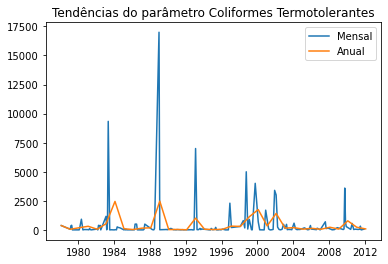

Oxigênio Dissolvido


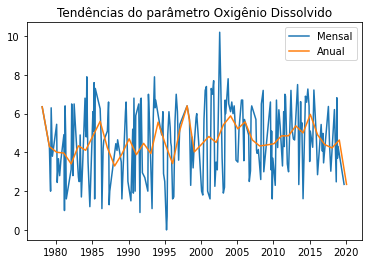

Turbidez


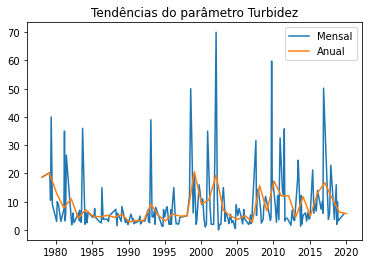

Fósforo Total


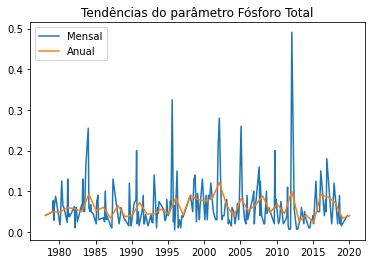

Sólido Total


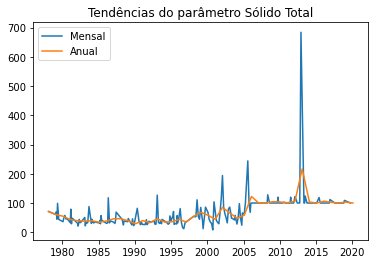

DBO (5, 20)


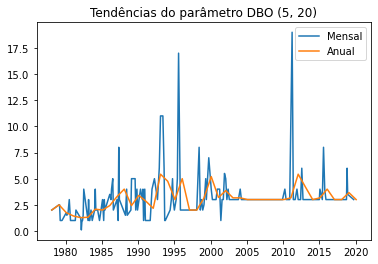

Temperatura da Água


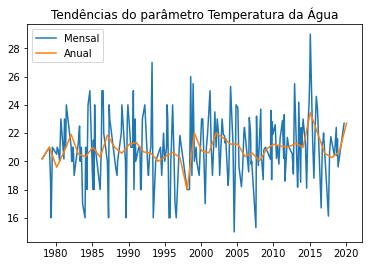

pH


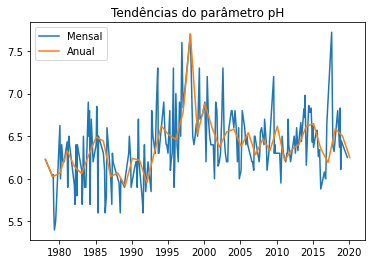

In [21]:
parameters = ['coliformes', 'od', 'turbidez', 'fosforo', 'solido', 'dbo', 'temperatura', 'ph']
df_resultado = pd.DataFrame(columns=['tecnica','parametro','amostras','mape','lag'])

DFmerge = pd.DataFrame()
for parameter in parameters:
    # Concatenating all the parameter files
    df = pd.read_csv('../../../data/CETESB/'+ parameter + '.csv',encoding='utf-8',sep=';')
    DFmerge = pd.concat([DFmerge, df])
    
    
for parameter in DFmerge['parametro'].unique():    
    DFmerged = DFmerge[(DFmerge['codigo_ponto'] == 'TIET02050') &
                      (DFmerge['parametro'] == parameter)] 
    
    DFmerged['data_coleta'] = pd.to_datetime(DFmerged['data_coleta'])
    DFmerged.index = DFmerged['data_coleta']    
    DFmerged1 = DFmerged.groupby([pd.Grouper(freq='1M'), 'parametro'])['valor'].mean().unstack()
    DFmerged2 = DFmerged.groupby([pd.Grouper(freq='12M'), 'parametro'])['valor'].mean().unstack()
    
    print(parameter)
    
    plt.plot(DFmerged1,label='Mensal')
    plt.plot(DFmerged2,label='Anual')
    plt.title('Tendências do parâmetro ' + parameter)
    plt.legend()
    plt.show()
    
    '''    
    dataframe1 = DFmerged.describe()
    print(dataframe1)
    '''    
